In [7]:
%pip install recordlinkage jellyfish seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import recordlinkage
from recordlinkage.datasets import load_febrl2
from recordlinkage.preprocessing import phonetic

# 加载 FEBRL 2 数据集（包含真实匹配标签）
df, true_links = load_febrl2(return_links=True)
print(f"Dataset shape: {df.shape}")        # (5000, 10) 包含5000条记录和若干属性列
print(f"True match pairs: {len(true_links)}")  # 真实匹配的记录对数量


Dataset shape: (5000, 10)
True match pairs: 1934


In [2]:
df

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956
rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,19290427,5967384
rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,19631225,3832742
...,...,...,...,...,...,...,...,...,...,...
rec-1487-org,thomas,green,44,tuthill place,holmeleigh,bonny hills,4740,vic,19420210,9334580
rec-1856-org,james,mcneill,42,archibald street,NaN,evans head,2250,nsw,19011207,4837378
rec-3307-org,paige,lock,7,a'beckett street,camboon,carina heights,2290,nsw,19871002,5142242


In [3]:
df.to_csv("febrl2.csv", index=True)

In [4]:

# 构造阻断键：Soundex(姓) + 名首字母
df['surname_soundex'] = phonetic(df['surname'].fillna(''), method='soundex')
df['first_initial'] = df['given_name'].str[0].fillna('')
df['block_key'] = df['surname_soundex'].fillna('') + df['first_initial']

# 基于阻断键生成候选记录对
indexer = recordlinkage.Index()
indexer.block('block_key')
candidate_pairs = indexer.index(df)
print(f"Candidate pairs count: {len(candidate_pairs)}")


Candidate pairs count: 5180


In [5]:
# 安装所需库（如未安装recordlinkage、jellyfish等库，可以取消下面两行的注释来安装）
# !pip install recordlinkage jellyfish textdistance

import pandas as pd
import recordlinkage
import jellyfish
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载 FEBRL 2 数据集及预处理
df, true_links = recordlinkage.datasets.load_febrl2(return_links=True)  # 加载数据集和真实匹配对
# 将姓名字段拼接为全名（假设数据集中包含 'given_name' 和 'surname' 列）
df['given_name'] = df['given_name'].fillna('')
df['surname'] = df['surname'].fillna('')
df['full_name'] = df['given_name'] + ' ' + df['surname']
# 构建全名列表，索引与 DataFrame 保持一致（注意：full_names 是 Python 列表，使用整数索引访问）
full_names = df['full_name'].tolist()

# 2. 阻断策略以减少比较对数
# 这里采用姓名首字母阻断：仅比较名字和姓氏首字母都相同的记录对
df['name_initials'] = df['given_name'].str[:1] + df['surname'].str[:1]
indexer = recordlinkage.Index()
indexer.block('name_initials')
candidate_pairs = indexer.index(df)  # 生成候选记录对 (MultiIndex)

# 3. 定义姓名匹配相似度算法
def jaccard_similarity(s1, s2):
    """计算两个字符串的Jaccard相似度（基于字符二元组bigram）。"""
    s1 = str(s1).lower()
    s2 = str(s2).lower()
    # 如果字符串非常短，特殊处理（避免无二元组的情况）
    if len(s1) < 2 or len(s2) < 2:
        return 1.0 if s1 == s2 else 0.0
    # 构建二元组集合
    grams1 = {s1[i:i+2] for i in range(len(s1)-1)}
    grams2 = {s2[i:i+2] for i in range(len(s2)-1)}
    # 计算Jaccard系数
    return len(grams1 & grams2) / len(grams1 | grams2)

# 准备 TF-IDF 向量，用于计算余弦相似度
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
tfidf_matrix = vectorizer.fit_transform(full_names)

# 4. 遍历候选对，使用各算法判定匹配对
# 使用集合存储预测匹配的记录对
predicted_matches = {
    'Levenshtein': set(),
    'Jaro-Winkler': set(),
    'Jaccard': set(),
    'Soundex': set(),
    'TF-IDF Cosine': set()
}

# 设定各算法的匹配判定阈值或条件
LEVENSHTEIN_MAX_DIST = 2         # Levenshtein距离阈值（<=2判为匹配）
JARO_WINKLER_MIN_SIM = 0.85      # Jaro-Winkler相似度阈值（>=0.85判为匹配）
JACCARD_MIN_SIM = 0.80           # Jaccard相似度阈值（>=0.80判为匹配）
TFIDF_MIN_COSINE = 0.80          # TF-IDF 余弦相似度阈值（>=0.80判为匹配）
# Soundex算法为编码相等判为匹配（无连续阈值）

# 遍历每对候选记录
for i, j in candidate_pairs:
    # 将字符串型记录ID映射为DataFrame中的整数位置索引
    idx_i = df.index.get_loc(i)
    idx_j = df.index.get_loc(j)
    name1 = full_names[idx_i]
    name2 = full_names[idx_j]
    # 计算五种算法的匹配情况
    # 1) Levenshtein距离
    dist = jellyfish.levenshtein_distance(name1, name2)
    if dist <= LEVENSHTEIN_MAX_DIST:
        # 将匹配对加入集合（确保加入前排序索引，以统一顺序）
        if idx_i < idx_j:
            predicted_matches['Levenshtein'].add((i, j))
        else:
            predicted_matches['Levenshtein'].add((j, i))
    # 2) Jaro-Winkler相似度
    sim_jw = jellyfish.jaro_winkler_similarity(name1, name2)
    if sim_jw >= JARO_WINKLER_MIN_SIM:
        if idx_i < idx_j:
            predicted_matches['Jaro-Winkler'].add((i, j))
        else:
            predicted_matches['Jaro-Winkler'].add((j, i))
    # 3) Jaccard相似度
    sim_jc = jaccard_similarity(name1, name2)
    if sim_jc >= JACCARD_MIN_SIM:
        if idx_i < idx_j:
            predicted_matches['Jaccard'].add((i, j))
        else:
            predicted_matches['Jaccard'].add((j, i))
    # 4) Soundex编码比较
    code1 = jellyfish.soundex(name1)
    code2 = jellyfish.soundex(name2)
    if code1 and code2 and code1 == code2:
        if idx_i < idx_j:
            predicted_matches['Soundex'].add((i, j))
        else:
            predicted_matches['Soundex'].add((j, i))
    # 5) TF-IDF 余弦相似度
    cosine_sim = (tfidf_matrix[idx_i] * tfidf_matrix[idx_j].T).A[0][0]
    if cosine_sim >= TFIDF_MIN_COSINE:
        if idx_i < idx_j:
            predicted_matches['TF-IDF Cosine'].add((i, j))
        else:
            predicted_matches['TF-IDF Cosine'].add((j, i))

# 将真实匹配对（true_links）转换为集合，便于比较评估
true_pairs = set()
for a, b in true_links:
    # 将 (a,b) 按索引顺序排序，确保顺序统一
    idx_a = df.index.get_loc(a)
    idx_b = df.index.get_loc(b)
    if idx_a < idx_b:
        true_pairs.add((a, b))
    else:
        true_pairs.add((b, a))

# 5. 计算评估指标：精确率（Precision）、召回率（Recall）、F1-score
metrics = []
total_true = len(true_pairs)
for algo, pred_pairs in predicted_matches.items():
    tp = len(pred_pairs & true_pairs)            # 真正例（匹配正确的数量）
    fp = len(pred_pairs) - tp                   # 假正例
    fn = len(true_pairs) - tp                   # 假负例
    precision = tp / len(pred_pairs) if len(pred_pairs) > 0 else 0.0
    recall = tp / total_true if total_true > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    metrics.append({
        'Algorithm': algo,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# 输出各算法的指标值
metrics_df = pd.DataFrame(metrics)
print("各算法的精确率 (Precision)、召回率 (Recall)、F1-score：")
print(metrics_df[['Algorithm', 'Precision', 'Recall', 'F1']].round(3).to_string(index=False))


各算法的精确率 (Precision)、召回率 (Recall)、F1-score：
    Algorithm  Precision  Recall    F1
  Levenshtein      0.728   0.669 0.697
 Jaro-Winkler      0.265   0.698 0.384
      Jaccard      0.777   0.459 0.577
      Soundex      0.245   0.614 0.350
TF-IDF Cosine      0.757   0.535 0.627


C:\Users\22601\AppData\Local\Temp\ipykernel_50408\4016387968.py:13: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x="Algorithm", y="Score", hue="Metric", data=metrics_melted, palette=palette)


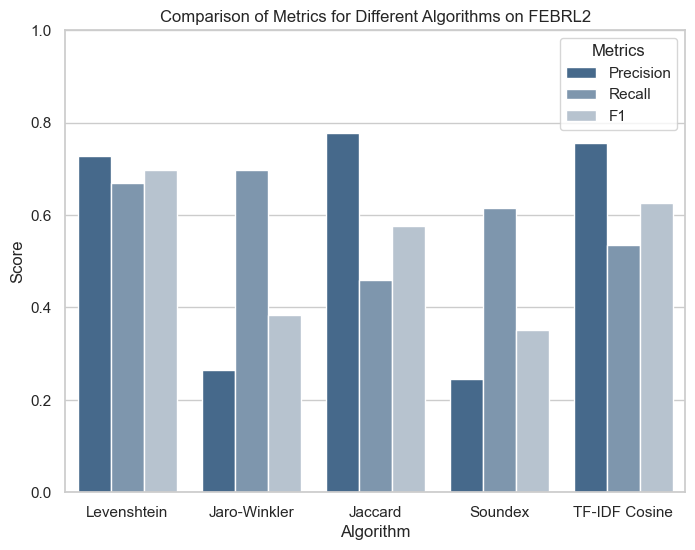

In [9]:
# 6. 使用 seaborn 绘制各算法指标对比的柱状图
sns.set_theme(style="whitegrid")
metrics_melted = pd.melt(metrics_df, id_vars="Algorithm", value_vars=["Precision", "Recall", "F1"],
                         var_name="Metric", value_name="Score")

plt.figure(figsize=(8,6))

# Create a color palette based on your color #3A6996
# We create 3 shades for the 3 metrics (Precision, Recall, F1)
palette = sns.light_palette("#3A6996", n_colors=4, reverse=True)

# Use the 'palette' argument in the barplot function
ax = sns.barplot(x="Algorithm", y="Score", hue="Metric", data=metrics_melted, palette=palette)

plt.ylim(0, 1.0)
plt.title("Comparison of Metrics for Different Algorithms on FEBRL2")
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.legend(title="Metrics")
plt.show()